# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
import seaborn as sns

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [3]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [0, 200, 325] 

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
samples_index = ['_Sample {}'.format(i) for i in range(0,len(samples))]
samples.index = samples_index 
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
_Sample 0,12669,9656,7561,214,2674,1338
_Sample 1,3067,13240,23127,3941,9959,731
_Sample 2,32717,16784,13626,60869,1272,5609


     Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0     66.4  83.9     65.0     7.5              68.2          63.0
200   24.3  91.8     94.5    77.7              94.1          41.4
325   94.1  95.0     83.4   100.0              58.2          97.3


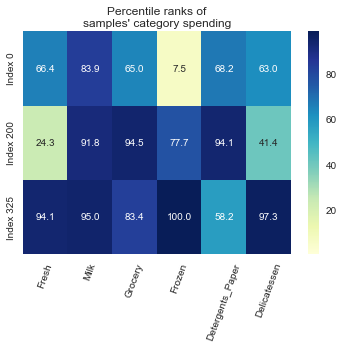

In [18]:
# look at percentile ranks
pcts = 100. * data.rank(axis=0, pct=True).iloc[indices].round(decimals=3)
print pcts

# visualize percentiles with heatmap
sns.heatmap(pcts, yticklabels=['Index '+str(x) for x in indices], annot=True, vmin=1, vmax=99, fmt='.1f', cmap='YlGnBu')
plt.title('Percentile ranks of\nsamples\' category spending')
plt.xticks(rotation=70, ha='center');

### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.


**Answer:**
To gain an understanding of what is going on, I am comparing these samples with the descriptive statistics of the data.   
##### Sample 0 

From the heatmap titled "Percentile ranks of samples' category spending," we can see that this sample represents an establishment that spends very little on `Frozen` category as compared to other product categories. Furthermore, this kind of establishment also spends significantly on `Milk`, at eighty-three percentile to be exact. My intuition leads me to think that this *might* be a **market**. 
___ 

##### Sample 1 
This kind of establishment spends less on `Delicatessen` at fourty-first percentile and even significantly less on the `Fresh` category. On the other categories, their spending is at well over the seventieth percentile range. My intuition leads me to believe this might be a place that serves meals and offers lodgings like a **hotel** or a **university** with a residence halls and adjoining cafetaria. 
___ 
##### Sample 2 
This establishment spends significantly on all categories with the exception of the `Detergents_Paper` category where their spending is limited to the fifty-eight percentile. My guess is that this sample represents a **wholesale retailer** like a "costco" or "Sam's club"

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [ ]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature

new_data_target = data['Grocery']
new_data = data.drop('Grocery', axis=1, inplace=False)


# TODO: Split the data into training and testing sets using the given feature as the target
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(new_data, new_data_target, 
                                                                     test_size=0.25, random_state=42)

# TODO: Create a decision tree regressor and fit it to the training set

from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)

print "r-squared score on training data: ", regressor.score(X_train, y_train)
print "r-squared score on testing data: ", regressor.score(X_test, y_test)

### Question 2
*Which feature did you attempt to predict?   
What was the reported prediction score?   
Is this feature necessary for identifying customers' spending habits?*   
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**

Which feature did you attempt to predict?   
  - I predicted the impact of the feature '`Grocery`' on customers' spending habits.   
  
What was the reported prediction score?   
  - The prediction score was 0.682   
  
Is this feature necessary for identifying customers' spending habits?
  - This score which tends towards being high indicates that it is not necessary for identifying customers' spending habits. The reason is as follows: when customers spend on `Grocery` they also spend on other features, which means w can't really decipher spending habits. What would be better is to regress on a feature that has a **low** $R^2$ score indicating low correlation.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

In [ ]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [ ]:
from scipy.stats import pearsonr

data_col_name = list(data.columns)

for index in range(len(data.columns)/2):
    for j in data.columns:
        
        pearson_corr, p_value = pearsonr(data[data_col_name[index]], data[j])
        if data_col_name[index] != j and pearson_corr > 0.5:
            print "{:<8}& {:<18}{:20}{:5.2f}".format(data_col_name[index], j, 
                                                 'Pearson’s correlation coefficient', pearson_corr)
            

In [ ]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='RdBu', fmt='+.2f')
    plt.xticks(rotation=70, ha='right');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**   
Are there any pairs of features which exhibit some degree of correlation?
  - The pairs '`Grocery`' and '`Detergents_Paper`' have a very strong correlation. From the scatterplot, one can see that the data for these two features looks like it could fit a nice diagonal. To formalize my intuition, I performed a pearson's correlation on these two features and got a 0.92 score, noting that a score of 1 is the highest a correlation can be.
  - Another pair was '`Grocery`' and '`Milk`'. From the scatterplot, you can kind of see a trending along the diagonal.


Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict?
 - My intuition was supported by a pearson correlation coefficient score of 0.73. 
 - This confirms my suspicions that '`Grocery`' is **not** a strong predictor of overall client spending habits.   
 
How is the data for those features distributed?
 - The data for these features is not normally distributed. Its skewed to the right and has a long tail.

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

In [ ]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data, dtype='float64')

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples, dtype='float64')

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [ ]:
# plot densities of log-transformed data
plt.figure(figsize=(8,4))
for col in data.columns:
    log_data[col].plot.kde()
plt.legend();
plt.grid(False);
plt.title('Densities of log-transformed data');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [ ]:
log_data_col_name = list(log_data.columns)

for index in range(len(log_data.columns)/2):
    for j in log_data.columns:
        
        pearson_corr, p_value = pearsonr(log_data[log_data_col_name[index]], log_data[j])
        if log_data_col_name[index] != j and pearson_corr > 0.5:
            print "{:<8}& {:<18}{:20}{:5.2f}".format(log_data_col_name[index], j, 
                                                 'Pearson’s correlation coefficient', pearson_corr)


In [ ]:
# Display the log-transformed sample data
display(log_samples)

### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [ ]:
outlier  = []
outlier_indices = []

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    temp_data = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(temp_data)
    outlier.append(dict(feature=feature, indices=temp_data.index.tolist()))
    outlier_indices += temp_data.index.tolist()
    
# OPTIONAL: Select the indices for data points you wish to remove
outliers = outlier_indices

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

In [ ]:
import operator

tmp = {}

for i in outlier:
    for j in i['indices']:
        if j in tmp.keys():
            tmp[j] += (i['feature'], 1)
        else:
            tmp[j] = (i['feature'], 1)
            
for key in tmp:
    if len(tmp[key]) > 2:
        print 'Record:{} is an outlier for \n\t\t{}'.format(key, [n for n in tmp[key] if type(n) == str ])

### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:**   
 
*Are there any data points considered outliers for more than one feature based on the definition above?*   
Record: 65 is an outlier for `'Fresh'`, `'Frozen'`   
Record: 66 is an outlier for `'Fresh'`, `'Delicatessen'`      
Record: 75 is an outlier for `'Grocery'`, `'Detergents_Paper'`     
Record: 128 is an outlier for `'Fresh'`, `'Delicatessen'`      
Record: 154 is an outlier for `'Milk'`, `'Grocery'`, `'Delicatessen'`   

*Should these data points be removed from the dataset?*   
These data points should be removed from the dataset   

*If any data points were added to the `outliers` list to be removed, explain why.*   
The algorithm that we will be using to cluster the data points, '`KMeans`' is *very sensitive* to outliers. Since this algorithm uses the distance from the centroids of the clusters, i.e. the means to calculate which data points belong to what cluster, leaving values that are very far off from the rest will influence the structure, leading to undesirable clusters.

![Effect of outliers on KMeans clustering](kmeans_outlier_clusters.png)

**NB**: It is important to that we removed 42 data points from our dataset which corresponds to 10% of the dataset. In this case we still have around 390 uniques data points for a problem with 6 variables. 

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [ ]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
pca.fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

In [ ]:
display(pca_results)

In [ ]:
# Produce a scatter matrix for pca reduced data
pd.scatter_matrix(reduced_data, alpha = 0.3, figsize = (6,6), diagonal = 'kde');

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the individual feature weights.


**Answer:**   
How much variance in the data is explained ***in total*** by the first and second principal component?   
unsurprisingly, dimensions 1 and 2 account for almost 72% of the variance in the data. One of the interesting aspects of PCA is that the most interesting dynamics occur only in the first *k* dimension, and then they fall off. In this case, I would say the first **3** components highlight some clear customer segments.    


What about the first four principal components?   
The first four principal components account for 93% of the variance in the dataset. For this analysis I have decided that a correlation value above 0.5+- is deemed important. 

#### First Principal Component Analysis - Dimension 1
The first principal component is strongly correlated with the feature `Detergents_Paper`. The first principal component increases with increasing `Detergents_Paper` spending. With a correlation score of 0.76, this suggests that this principal component is a measure of `Detergents_Paper`.

#### Second Principal Component Analysis - Dimension 2
The second principal component is strongly correlated with two features `Milk` and `Frozen`. The second principal component increases with increasing `Milk` and `Frozen` spending. This suggests that customers that spend large amounts on Milk also tend to spend large amounts on Frozen products.

#### Third Principal Component Analysis - Dimension 3
The third principal component is strongly correlated with two features `Fresh` and `Delicatessen`. The third principal component increases with increasing `Fresh` and increases with *decresing* `Delicatessen` spending. This suggests that customers that spend large amounts on Fresh also tend to spend very little on Delicatessen products.

#### Fourth Principal Component Analysis - Dimension 4
The fourth principal component is strongly correlated with the feature `Frozen`. The fourth principal component increases with increasing `Frozen` spending. With a correlation score of 0.71, this suggests that this principal component is a measure of `Frozen`.

Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.   
- The first dimension seems to represent customers who spend *significantly* on detergents and paper, spend okay on milk and groceries, and none to less on fresh produce and frozen products.
- Another way to understand these first four dimensions is that they each represent a *customer segment*

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [ ]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))
display(samples)

### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [ ]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])



### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [ ]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**   
What are the advantages to using a K-Means clustering algorithm? 
- Easy to understand and compute
- The clusters do not overlap
- It's efficient. The time requirement is $O(I*K*m*n)$ as long as the number of clusters is significantly less than m.
    - where $I$ is the number of iterations required for convergence
    - where $K$ is the number of clusters
    - where $m$ the number of points
    - where $n$ is the number of attributes   

What are the advantages to using a Gaussian Mixture Model clustering algorithm?   
- Allows for soft-classification, i.e., data point can belong to more than one cluster with probabilities
- If we believe that our dataset has some *hidden* phenomenon in it, this algorithm is well suited to finding it
- Its good for density estimation

Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?   
- I am going to go with a **KMeans** algorithm for the following reasons:
    - I want to have a clear delineation of who the various customer segmets are. KMeans gives hard partitions and will allow for this.
    - KMeans scales and is a simple and efficient algorithm unlike the Gaussian Mixture Model which does not scale. If we ever grow the dataset, this difference will save a lot of time in the future. 

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [ ]:
# TODO: Apply your clustering algorithm of choice to the reduced data 

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters = 2

clusterer = KMeans(n_clusters, init='k-means++', n_init=100)
clusterer.fit(reduced_data)
 

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.cluster_centers_

# TODO: Predict the cluster for each transformed sample data point
sample_preds =  clusterer.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

In [ ]:
meanSilhouetteScore = []
n = 10

for i in range(2, n):
    my_clusterer = KMeans(i, init='k-means++', n_init=100)
    my_clusterer.fit(reduced_data)
    my_preds = my_clusterer.predict(reduced_data)
    my_centers = my_clusterer.cluster_centers_
    my_sample_preds =  my_clusterer.predict(pca_samples)
    my_score = silhouette_score(reduced_data, my_preds)
    meanSilhouetteScore.append(my_score)
        

In [ ]:
ms = meanSilhouetteScore
## forward pad the array since KMeans doesn't allow clusters less than 2
ms.insert(0,0)
ms.insert(1,0)

## Plot the scores
plt.plot(ms, 'o-')
plt.title('Mean Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.xticks(np.arange(0, n, 1))
plt.yticks(np.arange(0, 0.6, 0.05))
plt.grid(True)
plt.show()

**Answer:**   
Which number of clusters has the best silhouette score?
- Based on the silhoutte score that was generated, the optimal number of clusters is 2

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

In [ ]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster presented in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [ ]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers =  np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

In [ ]:
data.describe().ix['25%']

In [ ]:
data.describe().ix['50%']

##### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**   

**Segment 0**'spends significantly on fresh and frozen products. I think this might be a ** supermarket**


**Segment 1**'s spending on milk, grocery, Frozen and detergents is around or over the 75% range for this dataset. I think this might be a place that caters to children/toddlers like a **child care center** or a **large restaurant chain** that serves breakfast. 
- I say this because they spend a significant amount on `Milk` which my intuition leads me to believe is either a place that serves a lot of children, or a place that serves a lot of breakfast.
- This place also consumes a significant amount of detergents and paper, they are doing a ton of laundry.



### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [ ]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

In [ ]:
display(samples)
display(true_centers)

In [ ]:
# check if samples' spending closer to segment 0 or 1
samples = samples.reset_index(drop=True)
df_diffs = (np.abs(samples-true_centers.iloc[0]) < np.abs(samples-true_centers.iloc[1])).applymap(lambda x: 0 if x else 1)

# see how cluster predictions align with similariy of spending in each category
df_preds = pd.concat([df_diffs, pd.Series(sample_preds, name='PREDICTION')], axis=1)
sns.heatmap(df_preds, annot=True, cbar=False, yticklabels=['sample 0', 'sample 1', 'sample 2'], square=True)
plt.title('Samples closer to\ncluster 0 or 1?')
plt.xticks(rotation=45, ha='center')
plt.yticks(rotation=0);


**Answer:**   
For each sample point, which customer segment from* ***Question 8*** *best represents it? 
- Sample point 0 predicted to be in Cluster 1
- Sample point 1 predicted to be in Cluster 1
- Sample point 2 predicted to be in Cluster 1

Are the predictions for each sample point consistent with this?
- Based on my intuition, **Sample 0** doesn't line up. I thought that sample was a small market, and *segment 1* more like a place to caters to feeding and caring for children.
- For **Sample 1** my reasoning holds. If I generalize *child-care center* to institutions that feed people and washes a lot of laundry like beddings and table cloths, then it makes sense that its **Sample 1** is assigned to cluster 1.
- For **Sample 2** doesn't line up. I thought of cluster 1 as a child-care center or restaurant, and **Sample 2** as a wholesale supermarket like Costo. From the clusters, you can see that this point is amongs the farthest away from the center, which corresponding to numerically larger data points, so perhaps it *still* falls in line with my intuition.

## Conclusion

### Question 10
Companies often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether that change affects its customers positively or negatively. The wholesale distributor wants to consider changing its delivery service from 5 days a week to 3 days a week, but will only do so if it affects their customers positively. *How would you use the customer segments you found above to perform an A/B test for this change?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**   

The first thing we do is isolate the change to the customer segments that bring in the least amount of revenue. Once we have run the A/B test, and we get positive results, then we can scale up the process to the other customer segments, making sure that we continue to monitor the impact of the change on the revenue that comes from those segments.   

We can't assume the change will affect all customers equally. It would be impractical to assume that their sources of revenue are similar. For example, let's take two hypothetical customer segments:
- Universities
- Hotels   

These two hypothetical verticals have vastly different sources of revenue. Universities get their revenue from tuition, grants, and returns from endowments. While hotels get the majority of their revenue from rooms. These revenue are based on different schedules. 

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a segment it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and has made estimates for each customer's annual spending of the six product categories. Knowing these estimates, the wholesale distributor wants to classify each new customer to one of the customer segments to determine the most appropriate delivery service.  
*Describe a supervised learning strategy you could use to make classification predictions for the ten new customers.*  
**Hint:** What other input feature could the supervised learner use besides the six product features to help make a prediction?

**Answer:**   
Classification   
Features:`{Fresh, Milk, Grocery, Frozen, DetergentsPaper, Delicatessen, Channel, Region, distCluster_[i] where i in {n = number of clusters}}`   
Labels: `{cluster labels}`   

We will take this as a classification task where the labels for our data will be the clusters they belong to. As such, the first thing we do is attach a label to each of our data point in our dataset. For classification to be effective in this context, we will generalize a binary classification problem to that of a multi-label classification.   

In addition to the six product categories, Channel and Region, I have created an engineered feature `'distCluster_[i]'`. This feature represented the distance value from the mean of each cluster that we have a label for. For my clustering algorithm, I used KMeans, which create hard partitions. I would like to leverage the ability to incorporate how far each data point is from the means of each of the clusters as another feature for my learner.   


### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

In [ ]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**   
How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution?    

![Results of KMeans Clustering on the reduced data](KMeansModelResults.png)

- The KMeans algorithm with 2 clusters does rather well. It correctly identified the **Retailers** cluster, and the **Hotels/Restaurants/Cafes** as can be seen from the image above.   

Would you consider these classifications as consistent with your previous definition of the customer segments?
Yes and no.   
- The **Retailer** cluster matches nicely to what I referred to as a ** supermarket**.
- The **Hotels/Restaurants/Cafes** also matches nicely as I previously said that I thought the place might be a **child care center** or a **large restaurant chain** that serves breakfast. 



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.